In [1]:
import os
import json
import numpy as np
import argparse
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import japanese_clip as ja_clip
from transformers import MLukeTokenizer, LukeModel

In [2]:
# # コマンドライン引数の処理
# parser = argparse.ArgumentParser(description="設定用プログラム")


# parser.add_argument("--num_workers", type = int, default = 16, help = "データローダが使用するCPUのスレッド数(GPUの総スレッド数の8割が推奨)")
# parser.add_argument("--reset_data", action = "store_true", help = "データセットを再作成するか")
# parser.add_argument("--use_unreal_image", action = "store_true", help = "現実写真以外を使用する")
# parser.add_argument("--use_word_image", action = "store_true", help = "文字を含む画像を使用する")
# parser.add_argument("--use_unique_noun_boke", action = "store_true", help = "固有名詞を含む大喜利を使用する")
# parser.add_argument("--use_caption", action = "store_true", help = "負例としてキャプションを使用する")
# parser.add_argument("--use_miss_boke", action = "store_true", help = "負例として別の画像の大喜利を使用する")
# parser.add_argument("--num_ratio_miss_boke", type = int, default = 1, help = "正例の何倍の別の画像の大喜利を使用するか")
# parser.add_argument("--epoch", type = int, default = 15, help = "学習反復回数")
# parser.add_argument("--batch_size", type = int, default = 64, help = "バッチサイズ")
# parser.add_argument("--learning_rate", type = float, default = 0.001, help = "学習率")
# parser.add_argument("--feature_dim", type = int, default = 1024, help = "モデルの特徴量次元数")


# args = parser.parse_args()

In [3]:
NUM_WORKERS = 16 # args.num_workers
RESET_DATA = False # args.reset_data

USE_UNREAL_IMAGE = False # args.use_unreal_image
USE_WORD_IMAGE = False # args.use_word_image
USE_UNIQUE_NOUN_BOKE = False # args.use_unique_noun_boke
USE_CAPTION = True # args.use_caption
USE_MISS_BOKE = True # args.use_miss_boke
NUM_RATIO_MISS_BOKE = 1 # args.num_ratio_miss_boke

EPOCH = 15 # args.epoch
BATCH_SIZE = 64 # args.batch_size
LEARNING_RATE = 0.0001 # args.learning_rate
FEATURE_DIM = 1024 # args.feature_dim

RESULT_DIR = f"../../results/Boke_Judge/{USE_UNREAL_IMAGE}_{USE_WORD_IMAGE}_{USE_UNIQUE_NOUN_BOKE}_{USE_CAPTION}_{USE_MISS_BOKE}_{NUM_RATIO_MISS_BOKE}_{EPOCH}_{BATCH_SIZE}_{LEARNING_RATE}_{FEATURE_DIM}/"

if not os.path.exists("../../results/Boke_Judge/"):
    os.mkdir("../../results/Boke_Judge/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
print(f"result directory: {RESULT_DIR}")
with open(f"{RESULT_DIR}config.json", "w") as f:
    json.dump({
        "USE_UNREAL_IMAGE": USE_UNREAL_IMAGE,
        "USE_WORD_IMAGE": USE_WORD_IMAGE,
        "USE_UNIQUE_NOUN_BOKE": USE_UNIQUE_NOUN_BOKE,
        "USE_CAPTION": USE_CAPTION,
        "USE_MISS_BOKE": USE_MISS_BOKE,
        "NUM_RATIO_MISS_BOKE": NUM_RATIO_MISS_BOKE,
        "EPOCH": EPOCH,
        "BATCH_SIZE": BATCH_SIZE,
        "LEARNING_RATE": LEARNING_RATE,
        "FEATURE_DIM": FEATURE_DIM
    }, f)

DATA_DIR = "../../datas/boke_data_assemble/"
IMAGE_DIR = "../../datas/boke_image/"
CLIP_IMAGE_FEATURE_DIR = "../../datas/encoded/clip_image_feature/"
CLIP_SENTENCE_FEATURE_DIR = "../../datas/encoded/clip_sentence_feature/"
LUKE_SENTENCE_FEATURE_DIR = "../../datas/encoded/luke_sentence_feature/"

result directory: ../../results/Boke_Judge/False_False_False_True_True_1_15_64_0.0001_1024/


In [4]:
# データセットの作成
if not os.path.exists(f"{RESULT_DIR}test_caption_datas.json") or RESET_DATA:
    
    boke_datas = list()
    caption_datas = list()

    max_num_boke = 0
    for JP in tqdm(os.listdir(DATA_DIR)):
        N = int(JP.split(".")[0])

        with open(f"{DATA_DIR}{JP}", "r") as f:
            a = json.load(f)

        image_information = a["image_information"]
        is_photographic_probability = image_information["is_photographic_probability"]
        ja_caption = image_information["ja_caption"]
        ocr = image_information["ocr"]

        # 現実写真以外を除去
        if not USE_UNREAL_IMAGE:
            if is_photographic_probability < 0.8: continue
            
        # 文字のある画像を除去
        if not USE_WORD_IMAGE:
            if len(ocr) != 0: continue

        bokes = a["bokes"]

        max_num_boke = max(max_num_boke, len(a["bokes"]))
        for i, B in enumerate(bokes):

            # 固有名詞を含む大喜利を除去
            if not USE_UNIQUE_NOUN_BOKE:
                if len(B["unique_nouns"]) != 0: continue

            boke_datas.append({
                "boke_number": i,
                "image_number": N
            })

        caption_datas.append({
            "caption_number": N,
            "image_number": N
        })

    # データセットの保存
    train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)
    train_caption_datas, test_caption_datas = train_test_split(caption_datas, test_size = 0.01)

    with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
        json.dump(train_boke_datas, f)
    with open(f"{RESULT_DIR}train_caption_datas.json", "w") as f:
        json.dump(train_caption_datas, f)

    with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
        json.dump(test_boke_datas, f)
    with open(f"{RESULT_DIR}test_caption_datas.json", "w") as f:
        json.dump(test_caption_datas, f)

# データセットの読み込み
else:
    with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
        train_boke_datas = json.load(f)
    with open(f"{RESULT_DIR}train_caption_datas.json", "r") as f:
        train_caption_datas = json.load(f)

    with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
        test_boke_datas = json.load(f)
    with open(f"{RESULT_DIR}test_caption_datas.json", "r") as f:
        test_caption_datas = json.load(f)

print(f"学習に用いる大喜利の数: {len(train_boke_datas)}\n", 
      f"学習に用いるキャプションの数: {len(train_caption_datas)}\n", 
      f"検証に用いる大喜利の数: {len(test_boke_datas)}\n", 
      f"検証に用いるキャプションの数: {len(test_caption_datas)}")

学習に用いる大喜利の数: 2297194
 学習に用いるキャプションの数: 251799
 検証に用いる大喜利の数: 23204
 検証に用いるキャプションの数: 2544


In [5]:
# データローダを作る関数
def make_dataloader(boke_datas, caption_datas, 
                    use_caption = False, use_miss_boke = False, num_ratio_miss_boke = 1,
                    num_workers = 4):
    """
        boke_datas: {"image_number":画像のお題番号 ,"boke_number":image_numberの画像に投稿されたboke_number番目の大喜利}からなるリスト
        caption_datas: {"image_number":画像のお題番号}からなるリスト
        use_caption: キャプションを負例として用いるか
        use_miss_boke: 他の画像の大喜利を負例として用いるか
        num_ratio_miss_boke: 正例の何倍の別の画像の大喜利を使用するか
        num_workers: データローダが使用するCPUのスレッド数
    """
    class LoadNpyDataset(Dataset):
        def __init__(self, image_file_paths, sentence_file_paths, teacher_signals):
            """
                image_file_paths: 画像の特徴量のパス(ディレクトリ，.npyを含めない)からなるリスト
                sentence_file_paths: 文章の特徴量のパス(boke/image_number/boke_number，またはcaption/image_number，.npyを含めない)からなるリスト
                teacher_signals: 教師信号(0または1)からなるリスト
            """
            if len(image_file_paths) != len(sentence_file_paths) and len(sentence_file_paths) != len(teacher_signals):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_paths = image_file_paths
            self.sentence_file_paths = sentence_file_paths
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            clip_image_feature = np.load(f"{CLIP_IMAGE_FEATURE_DIR}{self.image_file_paths[idx]}.npy")
            clip_sentence_feature = np.load(f"{CLIP_SENTENCE_FEATURE_DIR}{self.sentence_file_paths[idx]}.npy")
            luke_sentence_feature = np.load(f"{LUKE_SENTENCE_FEATURE_DIR}{self.sentence_file_paths[idx]}.npy")
            teacher_signal = self.teacher_signals[idx]

            return clip_image_feature, clip_sentence_feature, luke_sentence_feature, teacher_signal

    def collate_fn_tf(batch):
        clip_image_features = torch.Tensor(np.array([B[0] for B in batch]))
        clip_sentence_features = torch.Tensor(np.array([B[1] for B in batch]))
        luke_sentence_features = torch.Tensor(np.array([B[2] for B in batch]))
        teacher_signals = torch.Tensor(np.array([float(B[3]) for B in batch])[..., np.newaxis])
        
        return clip_image_features, clip_sentence_features, luke_sentence_features, teacher_signals

    image_file_numbers = list()
    sentence_file_numbers = list()
    teacher_signals = list()

    for D in boke_datas:
        image_file_numbers.append(D["image_number"])
        sentence_file_numbers.append(f'boke/{D["image_number"]}/{D["boke_number"]}')
        teacher_signals.append(1)

    if use_caption:
        for D in caption_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(f'caption/{D["image_number"]}')
            teacher_signals.append(0)
    
    if use_miss_boke:
        miss_boke_datas = list()

        # num_ratio_miss_boke回だけ負例を作る
        for _ in range(num_ratio_miss_boke):
            tmp_idx = np.random.randint(0, len(boke_datas), size = (len(boke_datas), ))
            for i, idx in tqdm(enumerate(tmp_idx)):
                # ランダムに選んだ大喜利の画像が正例の画像と同じ限り繰り返す
                while boke_datas[idx]["image_number"] == boke_datas[i]["image_number"]:
                    idx = np.random.randint(0, len(boke_datas))

                miss_boke_datas.append({
                    "boke_path": f'boke/{boke_datas[idx]["image_number"]}/{boke_datas[idx]["boke_number"]}',
                    "image_number": boke_datas[i]["image_number"]
                })
            
        for D in miss_boke_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["boke_path"])
            teacher_signals.append(0)
    
    print(f"num data: {len(teacher_signals)}")

    tmp = list(zip(image_file_numbers, sentence_file_numbers, teacher_signals))
    np.random.shuffle(tmp)
    image_file_numbers, sentence_file_numbers, teacher_signals = zip(*tmp)

    dataset = LoadNpyDataset(image_file_numbers, sentence_file_numbers, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = num_workers, 
        collate_fn = collate_fn_tf
    )

    return dataloader

In [6]:
# 大喜利適合判定モデルのクラス
class BokeJudgeModel(nn.Module):
    def __init__(self, cif_dim = 512, csf_dim = 512, lsf_dim = 768, feature_dim = 1024):
        """
            cif_dim: CLIPの画像の特徴量の次元数
            csf_dim: CLIPの文章の特徴量の次元数
            lsf_dim: Sentene-LUKEの文章の特徴量の次元数
        """
        super(BokeJudgeModel, self).__init__()
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, feature_dim)
        self.fc2 = nn.Linear(feature_dim, feature_dim)
        self.fc3 = nn.Linear(feature_dim, feature_dim)
        self.output_layer = nn.Linear(feature_dim, 1)
        
    def forward(self, cif, csf, lsf):
        """
            cif: CLIPの画像の特徴量
            csf: CLIPの文章の特徴量
            lsf: Sentence-LUKEの文章の特徴量
        """
        x = torch.cat([cif, csf, lsf], dim = 1)

        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        output = torch.sigmoid(self.output_layer(x))
        return output

In [7]:
# 二値分類の精度を計算する関数
def calculate_accuracy(teacher_signals, outputs, threshould = 0.5):
    """
        teacher_signals: 教師信号
        outputs: モデルの出力
        threshould: しきい値
    """
    return ((outputs > threshould).float() == teacher_signals).float().mean()

# 1イテレーション学習する関数
def train_step(model, optimizer, batch_data, batch_labels):
    optimizer.zero_grad()
    outputs = model(*batch_data)
    loss = nn.BCELoss()(outputs, batch_labels)
    accuracy = calculate_accuracy(batch_labels, outputs)
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy.item()

# 1イテレーション検証する関数
def evaluate(model, batch_data, batch_labels):
    with torch.no_grad():
        outputs = model(*batch_data)
        loss = nn.BCELoss()(outputs, batch_labels)
        accuracy = calculate_accuracy(batch_labels, outputs)
    return loss.item(), accuracy.item()

In [8]:
model = BokeJudgeModel(feature_dim = FEATURE_DIM)

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{RESULT_DIR}history.json"):
    with open(f"{RESULT_DIR}history.json", "r") as f:
        a = json.load(f)
        train_loss_history = a["train_loss"]
        train_accuracy_history = a["train_accuracy"]
        test_loss_history = a["test_loss"]
        test_accuracy_history = a["test_accuracy"]
    model.load_state_dict(torch.load(f"{RESULT_DIR}model_{len(train_loss_history):03}.pth"))
    SATRT_EPOCH = len(train_loss_history)
else:
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []
    SATRT_EPOCH = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch in range(SATRT_EPOCH, EPOCH):

    # train
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()
    train_dataloader = make_dataloader(train_boke_datas, train_caption_datas,
                                       use_caption = USE_CAPTION, use_miss_boke = USE_MISS_BOKE, num_ratio_miss_boke = NUM_RATIO_MISS_BOKE,
                                       num_workers = NUM_WORKERS)
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for CIF, CSF, LSF, TS in pb:
        CIF = CIF.to(device)
        CSF = CSF.to(device)
        LSF = LSF.to(device)
        TS = TS.to(device)

        loss, accuracy = train_step(model, optimizer, (CIF, CSF, LSF), TS)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})
        break
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # test
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()
    test_dataloader = make_dataloader(test_boke_datas, test_caption_datas,
                                      use_caption = USE_CAPTION, use_miss_boke = USE_MISS_BOKE, num_ratio_miss_boke = NUM_RATIO_MISS_BOKE,
                                       num_workers = NUM_WORKERS)
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for CIF, CSF, LSF, TS in pb:
        CIF = CIF.to(device)
        CSF = CSF.to(device)
        LSF = LSF.to(device)
        TS = TS.to(device)
        
        loss, accuracy = evaluate(model, (CIF, CSF, LSF), TS)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})
        break
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("-" * 25)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    torch.save(model.state_dict(), f"{RESULT_DIR}model_{len(train_loss_history):03}.pth")
    if os.path.exists(f"{RESULT_DIR}model_{len(train_loss_history) - 1:03}.pth"):
        os.remove(f"{RESULT_DIR}model_{len(train_loss_history) - 1:03}.pth")

    # 検証精度を更新した場合、重みを保存
    if max(test_accuracy_history) == test_accuracy:
        torch.save(model.state_dict(), f"{RESULT_DIR}best_model.pth")

    # 学習結果を保存
    with open(f"{RESULT_DIR}history.json", "w") as f:
        json.dump({
            "train_loss": train_loss_history,
            "train_accuracy": train_accuracy_history,
            "test_loss": test_loss_history,
            "test_accuracy": test_accuracy_history
        }, f)

<ipython-input-8-fdf76b1e07f9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{RESULT_DIR}model_{len(train_loss_history):03}.pth"))
229

num data: 4846187


Epoch 8/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.658, train_accuracy=0.625]
23204it [00:00, 1776483.16it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.699, test_accuracy=0.578]


Epoch: 8/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0008
-------------------------


2297194it [00:01, 1178285.74it/s]


num data: 4846187


Epoch 9/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.702, train_accuracy=0.547]
23204it [00:00, 1541214.77it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.714, test_accuracy=0.484]


Epoch: 9/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0006
-------------------------


2297194it [00:01, 1167125.37it/s]


num data: 4846187


Epoch 10/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.686, train_accuracy=0.578]
23204it [00:00, 1541727.47it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.691, test_accuracy=0.562]


Epoch: 10/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0007
-------------------------


2297194it [00:02, 1146483.38it/s]


num data: 4846187


Epoch 11/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.693, train_accuracy=0.547]
23204it [00:00, 1485554.69it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.702, test_accuracy=0.531]


Epoch: 11/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0007
-------------------------


2297194it [00:01, 1170393.23it/s]


num data: 4846187


Epoch 12/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.714, train_accuracy=0.406]
23204it [00:00, 1440971.11it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.691, test_accuracy=0.547]


Epoch: 12/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0007
-------------------------


2297194it [00:02, 1103395.40it/s]


num data: 4846187


Epoch 13/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.674, train_accuracy=0.656]
23204it [00:00, 1528363.04it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.691, test_accuracy=0.516]


Epoch: 13/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0007
-------------------------


2297194it [00:02, 1127814.87it/s]


num data: 4846187


Epoch 14/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.704, train_accuracy=0.359]
23204it [00:00, 1519794.97it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.693, test_accuracy=0.531]


Epoch: 14/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0007
-------------------------


2297194it [00:01, 1149510.05it/s]


num data: 4846187


Epoch 15/15:   0%|          | 0/75722 [00:01<?, ?it/s, train_loss=0.684, train_accuracy=0.531]
23204it [00:00, 1421980.77it/s]


num data: 48952


Evaluating:   0%|          | 0/765 [00:00<?, ?it/s, test_loss=0.693, test_accuracy=0.516]

Epoch: 15/15, Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0009, Test Accuracy: 0.0007
-------------------------


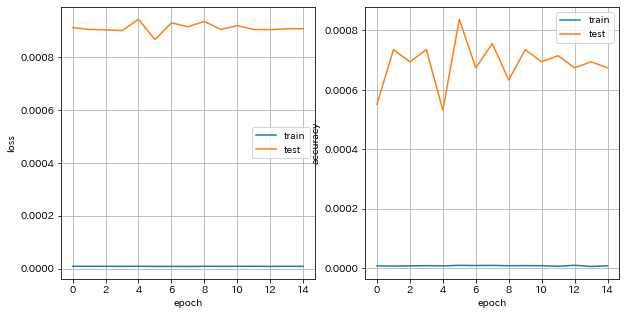

In [11]:
# 学習結果を描画
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()

fig.savefig(f"{RESULT_DIR}history.png")

In [12]:
# Sentence-LUKEのクラス
class SentenceLukeJapanese:
    def __init__(self, device = None):
        self.tokenizer = MLukeTokenizer.from_pretrained("sonoisa/sentence-luke-japanese-base-lite")
        self.model = LukeModel.from_pretrained("sonoisa/sentence-luke-japanese-base-lite",
                                               torch_dtype = torch.float16)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size = 256):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest",
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        return torch.stack(all_embeddings)

In [13]:
# 大喜利適合判定AI
class BokeJugeAI:
    def __init__(self, weight_path):
        """
            weight_path: 大喜利適合判定モデルの学習済みの重みのパス
        """
        # 大喜利適合判定AIの読み込み
        self.boke_judge_model = BokeJudgeModel()
        self.boke_judge_model.load_state_dict(torch.load(weight_path))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.boke_judge_model.to(self.device)
        self.boke_judge_model.eval()

        # CLIP
        self.clip_model, self.clip_preprocesser = ja_clip.load("rinna/japanese-clip-vit-b-16",
                                             cache_dir="/tmp/japanese_clip",
                                             torch_dtype = torch.float16,
                                             device = self.device)
        self.clip_tokenizer = ja_clip.load_tokenizer()

        # Sentence-LUKE
        self.luke_model = SentenceLukeJapanese()

    def __call__(self, image_path, sentence):
        """
            image_path: 判定したい大喜利のお題画像
            sentence: 判定したい大喜利
        """
        # CLIPによる特徴量への変換
        tokenized_sentences = ja_clip.tokenize(
            texts = [sentence],
            max_seq_len = 77,
            device = self.device,
            tokenizer = self.clip_tokenizer,
            )
        image = Image.open(image_path)
        preprcessed_image = self.clip_preprocesser(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            clip_image_features = self.clip_model.get_image_features(preprcessed_image)
            clip_sentence_features = self.clip_model.get_text_features(**tokenized_sentences)

        # Sentence-LUKEによる特徴量への変換
        luke_sentence_feature = self.luke_model.encode([sentence])

        # 大喜利適合判定AIの推論
        with torch.no_grad():
            outputs = self.boke_judge_model(clip_image_features,
                                        clip_sentence_features,
                                        luke_sentence_feature.to(self.device))

        return outputs.cpu().numpy()

In [14]:
# テストデータでモデルを評価する関数
def evaluate_model(weight_path, boke_data_path, caption_data_path,
                   thresholds = [0.1]):#, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """
        weight_path: 大喜利適合判定モデルの学習済みの重みのパス
        boke_data_path: {"image_number":お題画像の番号，"boke_number":image_numberの画像の何番目の大喜利か}のリストのjsonファイルのパス
        caption_data_path: {"image_number":お題画像の番号}のリストのjsonファイルのパス
    """
    def calculate_accuracy(predictions, threshold = 0.5):
        return sum(np.array(predictions) > threshold) / len(predictions)

    boke_judge_ai = BokeJugeAI(weight_path)

    # evaluate for caption
    print("evaluating caption...")
    predictions_for_caption = list()
    with open(caption_data_path, "r") as f:
        test_caption_datas = json.load(f)
    
    for D in tqdm(test_caption_datas):
        image_number = D["image_number"]
        with open(f"{DATA_DIR}{image_number}.json", "r") as f:
            ja_caption = json.load(f)["image_information"]["ja_caption"]
        judge = boke_judge_ai(f"../../datas/boke_image/{image_number}.jpg",
                            ja_caption) 
        predictions_for_caption.append(judge[0][0])
    
    # evaluate for boke
    print("evaluating boke...")
    predictions_for_boke = list()
    with open(boke_data_path, "r") as f:
        test_boke_datas = json.load(f)

    for D in tqdm(test_boke_datas):
        image_number = D["image_number"]
        boke_number = D["boke_number"]
        with open(f"{DATA_DIR}{image_number}.json", "r") as f:
            boke = json.load(f)["bokes"][boke_number]["boke"]
        judge = boke_judge_ai(f"{IMAGE_DIR}{image_number}.jpg",
                            boke) 
        predictions_for_boke.append(judge[0][0])

    # evaluate for miss boke
    print("evaluating miss boke...")
    predictions_for_miss_boke = list()
    test_miss_boke_datas = list()
    tmp_idx = np.random.randint(0, len(test_boke_datas), size = (len(test_boke_datas), ))
    for i, idx in tqdm(enumerate(tmp_idx)):
        # ランダムに選んだ大喜利の画像が正例の画像と同じ限り繰り返す
        while test_boke_datas[idx]["image_number"] == test_boke_datas[i]["image_number"]:
            idx = np.random.randint(0, len(test_boke_datas))

        test_miss_boke_datas.append({
            "boke_number": test_boke_datas[i]["boke_number"],
            "original_image_number": test_boke_datas[i]["image_number"],
            "miss_image_number": test_boke_datas[idx]["image_number"]
        })

    for D in tqdm(test_miss_boke_datas):
        original_image_number = D["original_image_number"]
        miss_image_number = D["miss_image_number"]
        boke_number = D["boke_number"]
        with open(f"{DATA_DIR}{original_image_number}.json", "r") as f:
            boke = json.load(f)["bokes"][boke_number]["boke"]
        judge = boke_judge_ai(f"{IMAGE_DIR}{miss_image_number}.jpg",
                            boke) 
        predictions_for_miss_boke.append(judge[0][0])

    result_dict = dict()
    for T in thresholds:
        result_dict[T] = {
            "caption": 1 - calculate_accuracy(predictions_for_caption, T),
            "boke": calculate_accuracy(predictions_for_boke, T),
            "miss_boke": 1 - calculate_accuracy(predictions_for_miss_boke, T)
        }
    
    return result_dict

In [ ]:

# テストデータでモデルを評価
evaluate_result_dict = evaluate_model(f"{RESULT_DIR}best_model.pth",
                                      boke_data_path = f"{RESULT_DIR}test_boke_datas.json", 
                                      caption_data_path = f"{RESULT_DIR}test_caption_datas.json")
with open(f"{RESULT_DIR}evaluation_result.json", "w") as f:
    json.dump(evaluate_result_dict, f)

x = list()
caption_evaluations = list()
boke_evaluations = list()
miss_boke_evaluations = list()
for K, V in evaluate_result_dict.items():
    x.append(K)
    caption_evaluations.append(V["caption"])
    boke_evaluations.append(V["boke"])
    miss_boke_evaluations.append(V["miss_boke"])

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()
ax.plot(x, caption_evaluations, label = "caption", color = "red")
ax.plot(x, boke_evaluations, label = "boke", color = "blue")
ax.plot(x, miss_boke_evaluations, label = "miss boke", color = "green")
ax.scatter(x, caption_evaluations, color = "red")
ax.scatter(x, boke_evaluations, color = "blue")
ax.scatter(x, miss_boke_evaluations, color = "green")
ax.legend()
ax.grid()
ax.set_ylabel("accuracy")
ax.set_xlabel("threshold")

fig.savefig(f"{RESULT_DIR}evaluation_result.png")

<ipython-input-13-9b97ec0fe3da>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.boke_judge_model.load_state_dict(torch.load(weight_path))
You are using the default leg

evaluating caption...


100%|██████████| 2544/2544 [01:14<00:00, 34.23it/s]


evaluating boke...


100%|██████████| 23204/23204 [07:42<00:00, 50.21it/s]


evaluating miss boke...


23204it [00:00, 1699874.77it/s]
 40%|████      | 9365/23204 [03:02<04:33, 50.61it/s]